## Aircraft Detection - Deep Learning Project

In [1]:
import os
import json
import random
import pandas as pd
import skimage.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
data_root = os.getcwd()
print(data_root)
#r"D:\RarePlanes\data"
train_imgs = os.path.join(data_root, r'data\train')
annot_dir = os.path.join(data_root, r'data\annot\rareplanes.json')
train_im_list = [z for z in os.listdir(train_imgs) if z.endswith('.png')]
f = open(annot_dir)
data = json.load(f)
print(len(train_im_list))
print(len(data['images']))
assert len(train_im_list) == len(data['images'])

def imgs_annot_aggregator(iter):
    print("Running imgs_annot_aggregator...")
    final = np.zeros((iter,4))
    bounding_boxes = []
    image_names = []
    instances_img = []
    amount_matches = []
    class_type = []
    for j in range(iter): 
        instances_img = []                        
        img = random.sample(train_im_list,1)
        image_names.append(img[0])
        for i in range(len(data['categories'])):
            if [data['categories'][i]['image_fname']] == img:
                instances_img.append(data['categories'][i]['id'])
        for l in range(len(instances_img)):
            for i in range(len(data['categories'])):
                if data['categories'][i]['id'] == instances_img[l]:
                    bounding_boxes.append(data['categories'][i]['bbox'])
                    class_type.append(data['categories'][i]['role'])
        amount_matches.append(len(instances_img))
    final = amount_matches, image_names, bounding_boxes, class_type
    return final, image_names

def bbox_points(data_annot):
    print("Running bbox_points...")
    name = []
    x_org = []
    y_org = []
    x_dist = []
    y_dist = []
    bbox = []
    class_type = []
    file_path = []
    itr = 0
    for i in range(len(data_annot[0])):
        for j in range(data_annot[0][i]):
            name.append(data_annot[1][i])
            class_type.append(data_annot[3][i])
            x_org.append(data_annot[2][j+itr][0])
            y_org.append(data_annot[2][j+itr][1])
            x_dist.append(data_annot[2][j+itr][2])
            y_dist.append(data_annot[2][j+itr][3])
            bbox.append([data_annot[2][j+itr][0],data_annot[2][j+itr][1],data_annot[2][j+itr][0]+data_annot[2][j+itr][2],data_annot[2][j+itr][1]+data_annot[2][j+itr][3]])
            file_path.append(os.path.join(train_imgs, data_annot[1][i]))
        itr = itr + data_annot[0][i]
    df = pd.DataFrame(
    {'name': name,
     'class': class_type,
     'x_org': x_org,
     'y_org': y_org,
     'x_dist': x_dist,
     'y_dist': y_dist,
     'bbox': bbox,
     'file_path': file_path
    })
    return df

final, img_name = imgs_annot_aggregator(1)
result = bbox_points(final)
result.head()

d:\RarePlanes
5815
5815
Running imgs_annot_aggregator...
Running bbox_points...


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,10_1040010039679A00_tile_144.png,Medium Civil Transport/Utility,-2.328306e-10,0.00000,31.877509,46.848584,"[-2.3283064365386963e-10, 0.0, 31.877509214216...",d:\RarePlanes\data\train\10_1040010039679A00_t...
1,10_1040010039679A00_tile_144.png,Medium Civil Transport/Utility,4.544755e+02,318.24986,40.737292,36.622414,"[454.4754797189962, 318.24985953234136, 495.21...",d:\RarePlanes\data\train\10_1040010039679A00_t...


## Testing random images

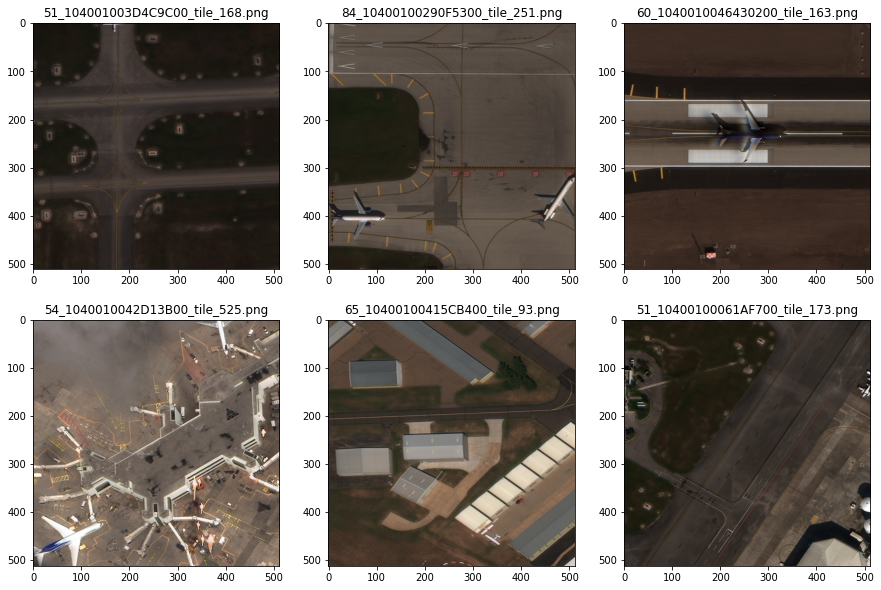

In [3]:
dir_tmp = train_imgs
rows, cols = 2, 3
figsize = 5
rand_selection = random.sample(train_im_list, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = os.path.join(train_imgs, rand_selection[i])
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

# Loading the entire Dataset

In [4]:
print(len(train_im_list))

final_data, img_name_data = imgs_annot_aggregator(100)#len(train_im_list))
result_data = bbox_points(final_data)

print(np.shape(result_data))

result_data.head()

5815
Running imgs_annot_aggregator...
Running bbox_points...
(334, 8)


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,114_104001000A497900_tile_129.png,Small Civil Transport/Utility,86.523549,417.617374,29.862229,28.379707,"[86.5235490500927, 417.6173742543906, 116.3857...",d:\RarePlanes\data\train\114_104001000A497900_...
1,114_104001000A497900_tile_129.png,Small Civil Transport/Utility,90.759326,367.423415,29.862229,32.191906,"[90.75932616367936, 367.4234154652804, 120.621...",d:\RarePlanes\data\train\114_104001000A497900_...
2,114_104001000A497900_tile_129.png,Small Civil Transport/Utility,100.501614,303.886759,73.278944,57.818358,"[100.5016135238111, 303.88675876893103, 173.78...",d:\RarePlanes\data\train\114_104001000A497900_...
3,114_104001000A497900_tile_129.png,Small Civil Transport/Utility,118.715455,210.487873,79.844399,62.477712,"[118.71545510739088, 210.48787342384458, 198.5...",d:\RarePlanes\data\train\114_104001000A497900_...
4,114_104001000A497900_tile_129.png,Small Civil Transport/Utility,340.564281,322.630072,27.426657,31.768328,"[340.5642814040184, 322.6300724912435, 367.990...",d:\RarePlanes\data\train\114_104001000A497900_...


In [5]:
class_dict = {'Small Civil Transport/Utility': 0, 
              'Medium Civil Transport/Utility': 1, 
              'Large Civil Transport/Utility': 2, 
              "Military Transport/Utility/AWAC": 3,
              "Military Fighter/Interceptor/Attack": 4,
              "Military Bomber": 5,
              "Military Trainer": 6
              }

result_data['class'] = result_data['class'].apply(lambda x: class_dict[x])

In [6]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,114_104001000A497900_tile_129.png,0,86.523549,417.617374,29.862229,28.379707,"[86.5235490500927, 417.6173742543906, 116.3857...",d:\RarePlanes\data\train\114_104001000A497900_...
1,114_104001000A497900_tile_129.png,0,90.759326,367.423415,29.862229,32.191906,"[90.75932616367936, 367.4234154652804, 120.621...",d:\RarePlanes\data\train\114_104001000A497900_...
2,114_104001000A497900_tile_129.png,0,100.501614,303.886759,73.278944,57.818358,"[100.5016135238111, 303.88675876893103, 173.78...",d:\RarePlanes\data\train\114_104001000A497900_...
3,114_104001000A497900_tile_129.png,0,118.715455,210.487873,79.844399,62.477712,"[118.71545510739088, 210.48787342384458, 198.5...",d:\RarePlanes\data\train\114_104001000A497900_...
4,114_104001000A497900_tile_129.png,0,340.564281,322.630072,27.426657,31.768328,"[340.5642814040184, 322.6300724912435, 367.990...",d:\RarePlanes\data\train\114_104001000A497900_...


In [7]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros([rows,cols])
    bb = bb.astype(int)
    Y[bb[1]:(bb[1]+bb[3]),bb[0]:(bb[0]+bb[2])] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[3],x[4],x[5]])

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Visualize Masks

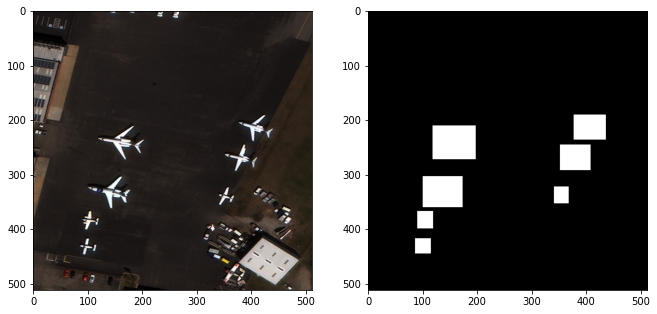

In [8]:
row = int(np.random.uniform(low=0, high=100, size=(1,)))

test_img = os.path.join(train_imgs, str(result_data['name'][row]))
rows_image = []

for i in range(100):    #len(train_im_list)):
    if result_data['name'][i] == result_data['name'][row]:
        rows_image.append(i)

im = skimage.io.imread(test_img)
bb = []
final_y = np.zeros((512,512))

for i in range(len(rows_image)):
    bb.append(create_bb_array(result_data.values[rows_image[i]]))
    Y = create_mask(bb[i],im)
    final_y = np.where(final_y == 0, Y, final_y)

figsize = 11
f, axarr = plt.subplots(1,2,figsize=(figsize*1, figsize*2))
axarr[0].imshow(im)
axarr[1].imshow(final_y, cmap='gray')

# Data Augmentation

In [9]:
new_size = 128
ratio = int(512/new_size)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    x = cv2.resize(x,(new_size,new_size) ) 
    bb[0] = int(bb[0]/ratio)
    bb[1] = int(bb[1]/ratio)
    bb[2] = int(bb[2]/ratio)
    bb[3] = int(bb[3]/ratio)
    return x, bb 

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


In [10]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,114_104001000A497900_tile_129.png,0,86.523549,417.617374,29.862229,28.379707,"[86.5235490500927, 417.6173742543906, 116.3857...",d:\RarePlanes\data\train\114_104001000A497900_...
1,114_104001000A497900_tile_129.png,0,90.759326,367.423415,29.862229,32.191906,"[90.75932616367936, 367.4234154652804, 120.621...",d:\RarePlanes\data\train\114_104001000A497900_...
2,114_104001000A497900_tile_129.png,0,100.501614,303.886759,73.278944,57.818358,"[100.5016135238111, 303.88675876893103, 173.78...",d:\RarePlanes\data\train\114_104001000A497900_...
3,114_104001000A497900_tile_129.png,0,118.715455,210.487873,79.844399,62.477712,"[118.71545510739088, 210.48787342384458, 198.5...",d:\RarePlanes\data\train\114_104001000A497900_...
4,114_104001000A497900_tile_129.png,0,340.564281,322.630072,27.426657,31.768328,"[340.5642814040184, 322.6300724912435, 367.990...",d:\RarePlanes\data\train\114_104001000A497900_...


d:\RarePlanes\data\train\18_1040050010DC4900_tile_3361.png


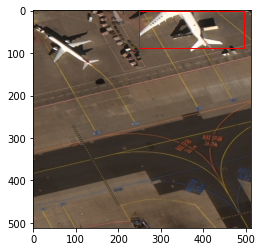

In [11]:
pic = int(np.random.uniform(low=0.0, high=100, size=None))

print(result_data['file_path'][pic])

im = cv2.imread(str(result_data['file_path'][pic]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, result_data['bbox'][pic])

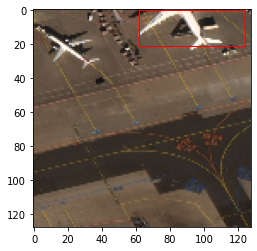

In [12]:
im, bb = transformsXY(str(result_data['file_path'][pic]), np.array(result_data['bbox'][pic],dtype=np.int32),True)
show_corner_bb(im, bb)

# Training


In [13]:
result_data = result_data.reset_index()

In [14]:
X = result_data[['file_path','bbox']]
Y = result_data['class']

X.head()

print(np.shape(X)[0])

334


In [15]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

# Pre Processing

#### Test image (reduced)

In [34]:
global final_data_frame 
final_data_frame = pd.DataFrame()

def image_merger():
    global final_data_frame
    ind = int(np.random.uniform(low=0.0, high=100, size=None))
    img_path_test = result_data['file_path'][ind]

    print(img_path_test)
    indx_number = []

    for i in range(len(result_data['file_path'])):
        if img_path_test == result_data['file_path'][i]:
            indx_number.append(i)
    print(indx_number)

    final_bbxs = []
    for i in range(len(indx_number)):
        bbox = result_data['bbox'][indx_number[i]]
        final_bbxs.append(bbox)
    
    print(final_bbxs)
    final_data_frame = final_data_frame.append({'path': img_path_test, 'final_bbx': final_bbxs}, ignore_index=True)


image_merger()

#final_data_frame.head()

print(final_data_frame['final_bbx'][0])

# print(final_data_frame["path"][0])

# for i in range(len(rows_image)):
#     bb.append(create_bb_array(img_path_test))
#     Y = create_mask(bb[i],im)
#     final_y = np.where(final_y == 0, Y, final_y)



# im, bbx = transformsXY(img_path_test,)

d:\RarePlanes\data\train\84_10400100290F5300_tile_231.png
[20]
[[142.22576995566487, 0.0, 222.51158301532269, 46.11892670672387]]
[[142.22576995566487, 0.0, 222.51158301532269, 46.11892670672387]]


C:\Users\artur\AppData\Local\Temp\ipykernel_7072\3067276861.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data_frame = final_data_frame.append({'path': img_path_test, 'final_bbx': final_bbxs}, ignore_index=True)


### Function that outputs x,y points in the center of the s*s tiles

In [184]:
def reference_points_tiles(img_path,s): 
    im = cv2.imread(str(img_path))
    r,c, *_ = im.shape
    r_incr = int(r/s)
    c_incr = int(c/s)
    x = []
    y = []

    for i in range(0,c,r_incr):
        for j in range(0,r,c_incr):
            x.append(int(i+(c_incr/2)))
            y.append(int(j+(r_incr/2)))
    return x,y,s

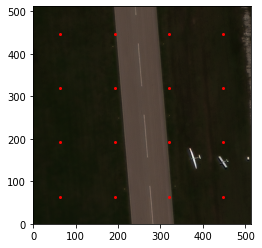

In [185]:

xs,ys,s = reference_points_tiles(img_path_test,4)
im = skimage.io.imread(img_path_test)

plt.figure()
plt.ylim(0,512)
plt.xlim(0,512)
plt.scatter(xs,ys, s=4, c='r')
plt.imshow(im)

### Function that generates bbox's based on a center point

In [175]:
def bbox_gen(x,y,s):
    s = 1/s+2
    bbox1 = (x-10*s,y-10*s,20*s,20*s)
    bbox2 = (x-50*s,y-25*s,100*s,50*s)
    bbox3 = (x-25*s,y-50*s,50*s,100*s)
    bbox4 = (x-25*s,y-50*s,50*s,100*s)
    bbox5 = (x-38*s,y-20*s,75*s,40*s)
    bbox6 = (x-20*s,y-15*s,40*s,30*s)

    bbox = [bbox1,bbox2,bbox3,bbox4,bbox5,bbox6]
    return bbox

In [176]:
bboxs = bbox_gen(xs[0],ys[0],s)
print(bboxs)
print(bboxs[0])

bboxs_list = []
for i in range(len(xs)):
    bbx = bbox_gen(xs[i],ys[i],s)
    bboxs_list.append(bbx)

#print(bboxs_list)

#print(bboxs_list[0])

[(41.5, 41.5, 45.0, 45.0), (-48.5, 7.75, 225.0, 112.5), (7.75, -48.5, 112.5, 225.0), (7.75, -48.5, 112.5, 225.0), (-21.5, 19.0, 168.75, 90.0), (19.0, 30.25, 90.0, 67.5)]
(41.5, 41.5, 45.0, 45.0)


<Figure size 432x288 with 0 Axes>

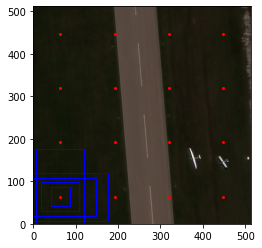

In [186]:
import matplotlib.patches as patches

plt.figure()
fig, ax = plt.subplots()
plt.ylim(0,512)
plt.xlim(0,512)
rect = patches.Rectangle((bboxs[0][0],bboxs[0][1]), bboxs[0][2], bboxs[0][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((bboxs[1][0],bboxs[1][1]), bboxs[1][2], bboxs[1][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((bboxs[2][0],bboxs[2][1]), bboxs[2][2], bboxs[2][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((bboxs[3][0],bboxs[3][1]), bboxs[3][2], bboxs[3][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((bboxs[4][0],bboxs[4][1]), bboxs[4][2], bboxs[4][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((bboxs[5][0],bboxs[5][1]), bboxs[5][2], bboxs[5][3], color='b', fill=False, lw=1)
ax.add_patch(rect)
ax.scatter(xs,ys, s=4, c='r')
ax.imshow(im)


### IoU - Interception over Union

In [187]:
def iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

# Training

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
class AircraftDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        y_bb = self.bb[idx]
        x = self.paths
        x, y_bb = transformsXY(str(path), np.array(self.bb[idx],dtype=np.int32), True)
        x.transpose(1, 0, 2).strides        
        return x, y_class, y_bb

In [18]:
train_ds = AircraftDataset(X_train['file_path'],X_train['bbox'] ,y_train, transforms=True)
valid_ds = AircraftDataset(X_val['file_path'],X_val['bbox'],y_val)

In [19]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


In [74]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        # resnet = models.resnet34(pretrained=True)
        # layers = list(resnet.children())[:8]
        # self.features1 = nn.Sequential(*layers[:6])
        # self.features2 = nn.Sequential(*layers[6:])
        self.conv1 = nn.Conv2d(3,6,3)
        self.classifier = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 7))
        self.bb = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 4))
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [76]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

model = create_model(7)
print(model)

c:\Users\artur\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\artur\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\artur/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [22]:
def val_metrics(model, valid_dl, C=1000):
    count = 0
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        print('Inside loop (val): ',count)
        batch = y_class.shape[0]
        x = x.float()
        x = torch.permute(x, (0, 3, 1, 2))
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
        count = count + 1 
    return sum_loss/total, correct/total

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    count = 0
    for i in range(epochs):
        print('Epoch number (train)',i,' of ', epochs)
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            print('Inside loop: ',count)
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            x = torch.permute(x, (0, 3, 1, 2))
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            count = count + 1 
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [23]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [24]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=2)

Epoch number (train) 0  of  2
Inside loop:  0
Inside loop:  1
Inside loop:  2
Inside loop:  3
Inside loop (val):  0
train_loss 3.024 val_loss 3.057 val_acc 0.052
Epoch number (train) 1  of  2
Inside loop:  4
Inside loop:  5
Inside loop:  6
Inside loop:  7
Inside loop (val):  0
train_loss 2.943 val_loss 3.025 val_acc 0.052


2.942796325683594